本次任务：
    将采集的多个表格的数据字段整合到主播个人信息表(pht表)中，最终整合结果如下所示：
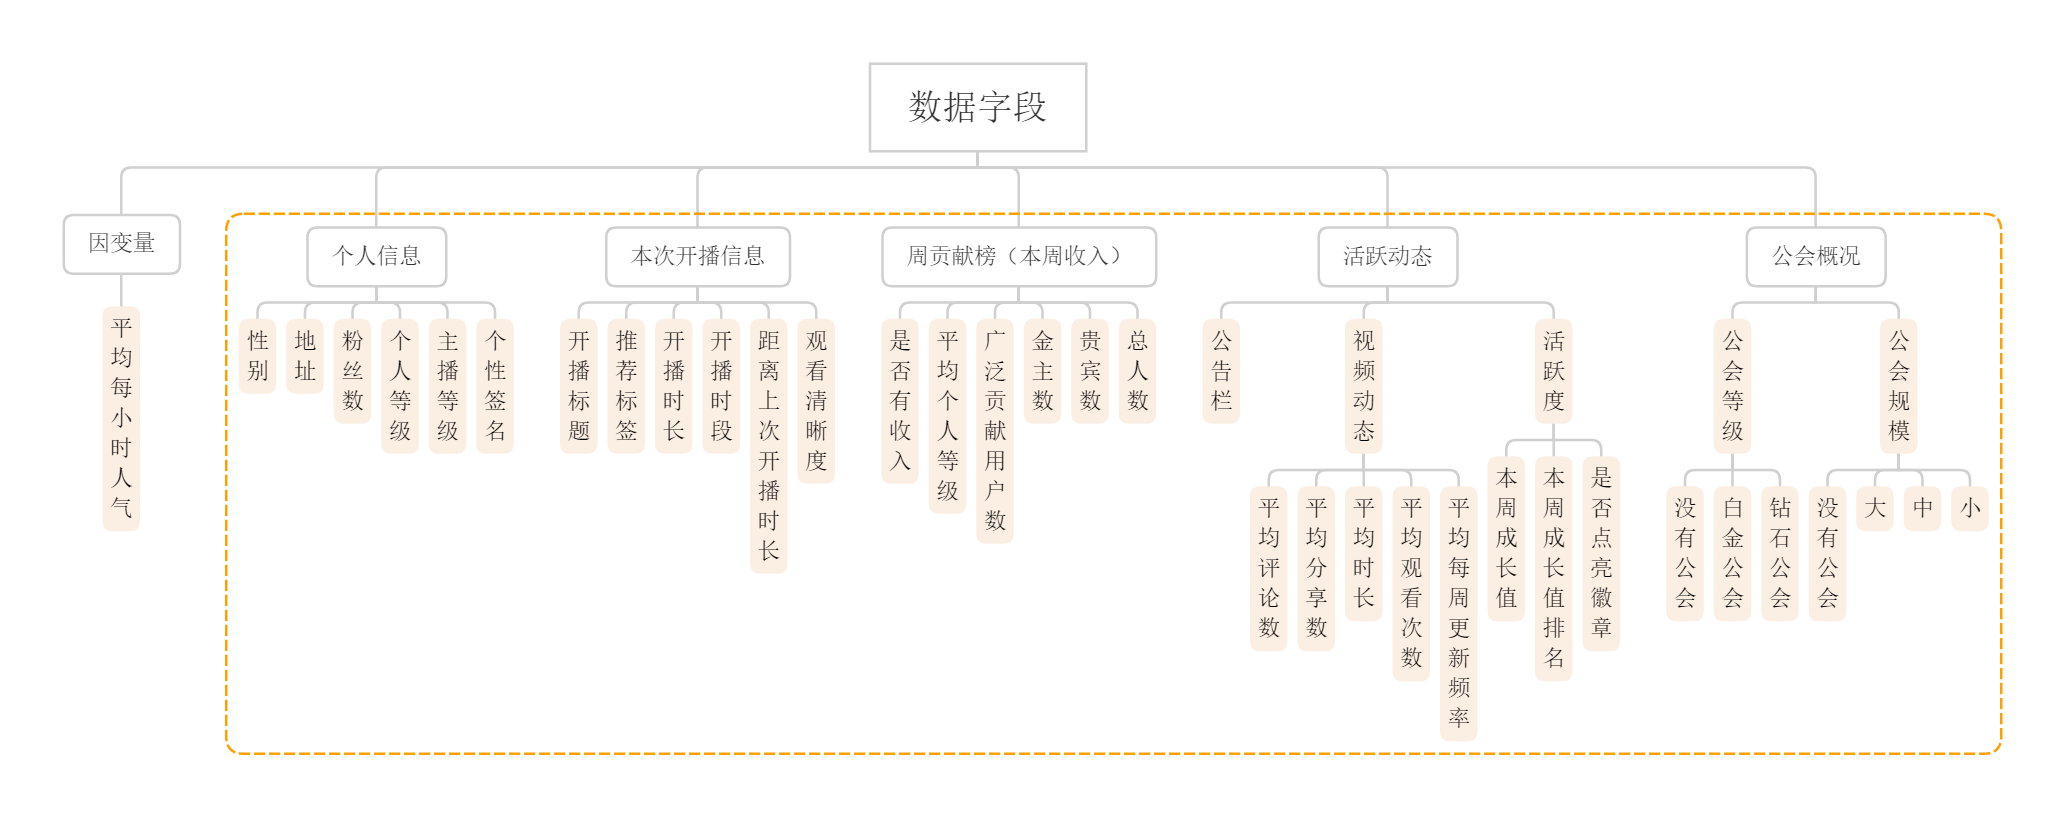

In [1]:
# 导入包  
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' # 设置图片清晰度
plt.rcParams['font.sans-serif'] = ['Simsun']   # 指定默认字体 Simsun为宋体
plt.rcParams['axes.unicode_minus'] = False     # 解决保存图像时负号‘-’显示为方块的问题

from datetime import datetime
import time, re

pd.set_option('display.max_columns', None)    # 显示所有列

In [2]:
# pht表：主播id表
pht = pd.read_csv('data\用户id.csv')

In [3]:
pht

用户id
0         1820796294
1         2183525275
2         2334560814
3         1016578758
4         1018667693
...              ...
10956     2323517119
10957  1279532989136
10958     2214316071
10959     1746647510
10960      136907042

[10961 rows x 1 columns]

10961位主播的用户id。接下来将对其他表的字段整合到pht表中。

#### 周贡榜的信息合并

In [4]:
wc = pd.read_csv('data\周贡献榜.csv')
wc.用户id = wc.用户id.astype(int)
# wc.drop(columns=['iSFFlag','sLogo','tNobleLevel'], inplace=True)   # 删除一些没有用信息的列

In [5]:
wc.head()
print('wc表共有%s条样本。'%wc.shape[0])

wc表共有45018条样本。


wc表的字段：  
- lUid：打赏的用户id
- 用户id：主播的id
- iScore：打赏金额
- iGuardLevel：开通的守护者等级，0表示未开通
- iNobleLevel：贵族等级
- iUserLevel：用户平台等级

###### 主播吸金程度

贡献榜总人数：主播当前贡献榜上的总用户数，由于数据获取的限制，最多只显示50名  
<font color='#73BE71'>主播对用户打赏的吸金程度</font>

In [6]:
a = wc.groupby('用户id').lUid.count().rename('贡献榜总人数').reset_index()
pht = pd.merge(pht, a, on='用户id', how='left')
pht['贡献榜总人数'].fillna(0, inplace=True)

贡献榜总金额：主播当前贡献榜上总的贡献金额，单位：金豆  
<font color='#73BE71'>主播吸金程度</font>

In [7]:
a = wc.groupby('用户id').iScore.sum().rename('贡献榜总金额').reset_index()
pht = pd.merge(pht, a, on='用户id', how='left')
pht['贡献榜总金额'].fillna(0, inplace=True)

是否有收入：主播当前贡献榜上是否存在贡献  
<font color='#73BE71'>主播吸金程度</font>

###### 主播吸引打赏的用户群体的等级特征

In [8]:
a = wc.drop_duplicates('lUid').lUid.values
pht['是否有收入'] = pht.用户id.isin(a).map({True:1, False:0})
pht['是否有收入'] = pht.贡献榜总金额.apply(lambda x: 1 if x>0 else 0)

贡献榜平均用户等级：主播当前贡献榜上的用户的平均等级，缺失值用-1填充，表示无贡献用户  
<font color='#73BE71'>主播吸引打赏的用户群体的等级特征</font>

In [91]:
a = wc.groupby('用户id').iUserLevel.mean().rename('贡献榜平均用户等级').reset_index()
pht = pd.merge(pht, a, on='用户id', how='left')
pht['贡献榜平均用户等级'].fillna(0, inplace=True)   # 缺失值

高等级用户数：主播当前贡献榜上的高等级用户数量（直播观看等级大于5的用户数量）  
<font color='#73BE71'>主播吸引打赏的用户群体的等级特征</font>

In [10]:
wc.loc[wc[wc.iUserLevel>16].index, '是否为高等级用户'] = 1
a = wc.groupby('用户id').是否为高等级用户.sum().rename('高等级用户数')
pht = pd.merge(pht, a, on='用户id', how='left')
pht['高等级用户数'].fillna(0, inplace=True)

高等级用户数占比：主播当前贡献榜上的高等级用户的数量占比  
<font color='#73BE71'>主播吸引打赏的用户群体的等级特征</font>

In [11]:
pht['高等级用户数占比'] = (pht['高等级用户数']/pht['贡献榜总人数']).fillna(0)

###### 主播吸引打赏的用户群体的财力情况

贵族数：主播当前贡献榜上的用户中贵族数量，缺失值用0填充  
<font color='#73BE71'>主播吸引打赏的用户群体的财力情况</font>

In [12]:
wc.loc[wc[wc.iNobleLevel==0].index , 'iNobleLevel'] = np.nan
a = wc.groupby('用户id').iNobleLevel.count().rename('贵族数').reset_index()
pht = pd.merge(pht, a, on='用户id', how='left')
pht['贵族数'].fillna(0, inplace=True)

金主数量：主播当前贡献榜上的金主数量（贡献排名TOP 5\%的打赏用户为金主）  
<font color='#73BE71'>主播吸引打赏的用户群体的财力情况</font>

In [13]:
a = wc.iScore.sort_values(ascending=False)
wc['是否金主'] = wc.index.isin(a[:int(len(a)/5)].index)
wc['是否金主'] = wc['是否金主'].map({True:1, False:0})

a = wc.groupby('用户id').是否金主.sum().rename('金主数量')
pht = pd.merge(pht, a, on='用户id', how='left')
pht['金主数量'].fillna(0, inplace=True)

贡献榜人均金额：主播当前贡献榜上的人均打赏金额，单位：金豆  
<font color='#73BE71'>主播吸引打赏的用户群体的财力情况</font>

In [14]:
pht['贡献榜人均金额'] = (pht['贡献榜总金额']/pht['贡献榜总人数']).fillna(0)

###### 主播吸引打赏的用户群体的专一程度

广泛贡献用户数：主播当前贡献榜上的广泛贡献用户数  
对5个以上主播打赏过的用户（由于数据爬取的时效性，这里有隐含条件：时间==7天内）。  
<font color='#73BE71'>主播吸引打赏的用户群体的专一程度</font>

In [15]:
wc

lUid   iScore  iGuardLevel  iNobleLevel  \
0         1786502568  1941400            0          2.0   
1      1199515156356  1798200            0          5.0   
2         1698832695   657400            0          1.0   
3         1356924630   503200            0          4.0   
4      1199573401591   498000            0          1.0   
...              ...      ...          ...          ...   
45013     1464086656     5000            0          NaN   
45014     1632134593     3700            0          NaN   
45015     1707464702     1000            0          NaN   
45016      880783781    33000            0          1.0   
45017  1279518128905      100            0          2.0   

                                                   sLogo  iUserLevel  \
0      https://huyaimg.msstatic.com/avatar/1033/6b/7a...          29   
1      https://huyaimg.msstatic.com/avatar/1031/93/d0...          15   
2      https://huyaimg.msstatic.com/avatar/1030/30/f1...          16   
3      https://huyaimg.msstatic.com/avatar/1096/d6/cf...          19   
4      https://huyaimg.msstatic.com/avatar/1075/5c/91...           2   
...                                                  ...         ...   
45013  http://huyaimg.msstatic.com/avatar/1060/f6/0b9...          10   
45014  http://huyaimg.msstatic.com/avatar/1060/2a/572...           6   
45015  https://huyaimg.msstatic.com/avatar/1075/26/e4...           5   
45016  https://huyaimg.msstatic.com/avatar/1006/95/fa...          25   
45017  https://huyaimg.msstatic.com/avatar/1087/0c/25...          22   

                              tNobleLevel  iSFFlag        用户id  是否为高等级用户  是否金主  
0      {'iNobleLevel': 2, 'iAttrType': 0}        0  1820796294       1.0     1  
1      {'iNobleLevel': 5, 'iAttrType': 0}        0  1820796294       NaN     1  
2      {'iNobleLevel': 1, 'iAttrType': 0}        0  1820796294       NaN     1  
3      {'iNobleLevel': 4, 'iAttrType': 0}        0  1820796294       1.0     1  
4      {'iNobleLevel': 1, 'iAttrType': 0}        0  1820796294       NaN     1  
...                                   ...      ...         ...       ...   ...  
45013  {'iNobleLevel': 0, 'iAttrType': 0}        0 -2147483648       NaN     0  
45014  {'iNobleLevel': 0, 'iAttrType': 0}        0 -2147483648       NaN     0  
45015  {'iNobleLevel': 0, 'iAttrType': 0}        0 -2147483648       NaN     0  
45016  {'iNobleLevel': 1, 'iAttrType': 0}        0 -2147483648       1.0     0  
45017  {'iNobleLevel': 2, 'iAttrType': 0}        0 -2147483648       1.0     0  

[45018 rows x 11 columns]

In [16]:
a = wc.groupby('lUid').iScore.count(); a = a[a>3].index
wc['是否为广泛贡献用户'] = wc.lUid.isin(a).map({True:1, False:0})
a = wc.groupby('用户id').是否为广泛贡献用户.sum().rename('广泛贡献用户数').reset_index()
pht = pd.merge(pht, a, on='用户id', how='left')
pht['广泛贡献用户数'].fillna(0, inplace=True)

[守护者](https://blog.huya.com/product/639)个数：主播当前贡献榜上的守护者个数  
> 贵族和守护者的区别：守护者比贵族更加侧重对主播专一的喜爱。因为守护者只在当前开通的直播间有牌面，而贵族在哪个直播间都有牌面。   

<font color='#73BE71'>主播吸引打赏的用户群体对主播的专一程度</font>

In [88]:
Guard_dict = wc.groupby('用户id').iGuardLevel.count().to_dict()
pht['守护者个数'] = pht.用户id.map(Guard_dict)
pht.守护者个数.fillna(0, inplace=True)

#### 视频动态的信息合并

In [18]:
iv = pd.read_csv('data\视频动态.csv')
iv.drop_duplicates(inplace=True)
iv['cTime'] = iv.cTime.astype('datetime64')
iv = iv.rename(columns={'uid':'用户id'})       # 重命名uid
# 提取字段
iv['观看次数'] = iv.videoInfo.apply(lambda x: eval(x)['videoPlayNum'])
# 观看时长
start_time = datetime.strptime('1900-1-1', '%Y-%m-%d')
iv['视频时长'] = iv.videoInfo.apply(lambda x: eval(x)['videoDuration'])
iv['视频时长'] = iv.视频时长.apply(lambda x: datetime.strptime(x, '%M:%S') if len(x)==5 else datetime.strptime(x, '%H:%M:%S'))
iv['视频时长'] = iv.视频时长.apply(lambda x: (x - start_time).seconds)

In [19]:
print('iv表共有%s条样本。'%iv.shape[0])

iv表共有27172条样本。


iv表字段：  
- 用户id：主播的id
- title：视频标题
- favorCount：点赞数  
- commentCount：评论数
- shareCount：分享数
- comment：评论内容
- cTime：发布时间
- roomId：直播间id
- 观看次数
- 视频时长

视频平均时长  
<font color='#73BE71'>主播视频的时长特点</font>

In [20]:
a = iv.groupby('用户id').视频时长.mean().rename('视频平均时长')
pht = pd.merge(pht, a, on='用户id', how='left')

每周视频更新频率  
<font color='#73BE71'>主播对视频动态的维护程度</font>

In [21]:
a = iv.groupby('用户id')[['cTime']].resample(rule='W', on='cTime', how='count').groupby(level=0).mean()  # 运行时间较长
b = a.groupby(level=0).mean().rename(columns={'cTime':'视频平均每周更新频率'})
pht = pd.merge(pht, b, on='用户id', how='left')

D:\software\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1558: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  return get_resampler_for_grouping(self, rule, *args, **kwargs)


###### 视频的受欢迎程度  
点赞、分享、收藏、评论

视频平均点赞数  
<font color='#73BE71'>视频的受欢迎程度</font>

In [22]:
a = iv.groupby('用户id').favorCount.mean().rename('视频平均点赞数')
pht = pd.merge(pht, a, on='用户id', how='left')

视频平均评论数   
<font color='#73BE71'>视频的受欢迎程度</font>

In [23]:
a = iv.groupby('用户id').commentCount.mean().rename('视频平均评论数')
pht = pd.merge(pht, a, on='用户id', how='left')

视频平均分享数   
<font color='#73BE71'>视频的受欢迎程度</font>

In [24]:
a = iv.groupby('用户id').shareCount.mean().rename('视频平均分享数')
pht = pd.merge(pht, a, on='用户id', how='left')

视频平均观看次数  
<font color='#73BE71'>视频的受欢迎程度</font>

In [25]:
a = iv.groupby('用户id').观看次数.mean().rename('视频平均观看次数')
pht = pd.merge(pht, a, on='用户id', how='left')

对有关视频的字段进行缺失值填充，填充为0，即没有发布视频的主播就没有视频相关的数据

In [26]:
pht.loc[:, '视频平均时长': '视频平均观看次数'] = pht.loc[:, '视频平均时长': '视频平均观看次数'].fillna(0)

#### 公会信息合并

In [27]:
channel = pd.read_csv('data\用户id-公会数据.csv')

channel表字段：
- 用户id：主播的id
- isPlaintum：是否加入公会
- channelID：公会id
- name：公会名称
- isDiamond：是否为钻石公会

In [28]:
print('channel表共有%s条样本。'%channel.shape[0])

channel表共有11145条样本。


是否为钻石公会：True：钻石，False：白金，NaN：无公会  
<font color='#73BE71'>主播所在的公会等级情况</font>

In [29]:
pht = pd.merge(pht, channel[['用户id', 'isDiamond']], on='用户id', how='left')
pht.rename(columns={'isDiamond':'是否为钻石公会'}, inplace=True)
pht['是否为钻石公会'] = pht.是否为钻石公会.map({True:'钻石', False:'白金'})
pht['是否为钻石公会'].fillna('无', inplace=True)

公会规模：主播所在的公会规模大小，在channel表出现大于100位主播的公会为大规模，20-100位主播的公会为中等规模，0-20位主播的公会为小规模，`无`表示没有入公会。  
<font color='#73BE71'>主播所在的公会规模</font>

In [30]:
a = channel.channelId.value_counts()
bins = [-1, 20, 100, 1000]; labels = ['小', '中', '大']
channel_size_dic = pd.cut(a, bins=bins, labels=labels).to_dict()
channel['公会规模'] = channel.channelId.map(channel_size_dic)
pht = pd.merge(pht, channel[['用户id','公会规模']], on='用户id')
pht['公会规模'].fillna('无', inplace=True)

将以上整理为“公会概况”  
将指标拆解为哑变量：大规模钻石公会、中规模钻石公会、小规模钻石公会、大规模白金公会、中规模白金公会、小规模白金公会、无公会。  
<font color='#73BE71'>反映主播所在公会的等级情况和规模</font>

In [31]:
pht['公会概况'] = pht[['是否为钻石公会','公会规模']].apply(lambda x: x[0]+x[1]+'规模公会' if x[0]!='无' else '无公会', axis=1)

In [32]:
# 查看数据概况
pht.公会概况.value_counts()

无公会        4705
白金小规模公会    2691
白金中规模公会    2238
钻石中规模公会     738
钻石小规模公会     446
钻石大规模公会     143
Name: 公会概况, dtype: int64

#### 本次开播信息合并 

ht表：每隔半小时爬取一次英雄联盟直播专区的在播情况，包括直播主标题，当前总人气，直播间推荐标签，是否有蓝光功能，蓝光清晰度等信息。

In [33]:
ht = pd.read_csv(r'data\4月4日数据.csv')
ht.fillna(method='bfill', inplace=True)        # 填充抓取时间的缺失值
ht['get_time'] = ht.get_time.map(time.localtime).map(lambda x: time.strftime("%Y--%m--%d %H:%M:%S", x)).astype('datetime64')  # 时间戳转日期格式
ht = ht.rename(columns={'uid':'用户id'})        # 重命名列名

ht表的字段：
- 用户id：主播id
- get_time：该条信息获取时间
- totalCount：当前总人气
- roomName：直播间标题
- recommendStatus：房间推荐状态
- isBluRay：是否有蓝光
- bluRayMBitRate：蓝光分辨率
- liveSourceType：直播类型（官方赛事、直播回放等）
- attribute：标签内容（英雄名、大神推荐、魅力新星等）
- profileRoom：直播间id
- isRoomPay：是否为付费观看

ht表的`attribute`字段解析：
- ListPos2字典存储的是英雄名
- ListPos1字典存储的是直播推荐标签

##### 主播的平均开播人气  
主播当天被记录下来的人气的平均值

In [34]:
a = ht.groupby('用户id').totalCount.mean().sort_values().rename('平均人气').reset_index()
pht = pd.merge(a, pht, on='用户id')

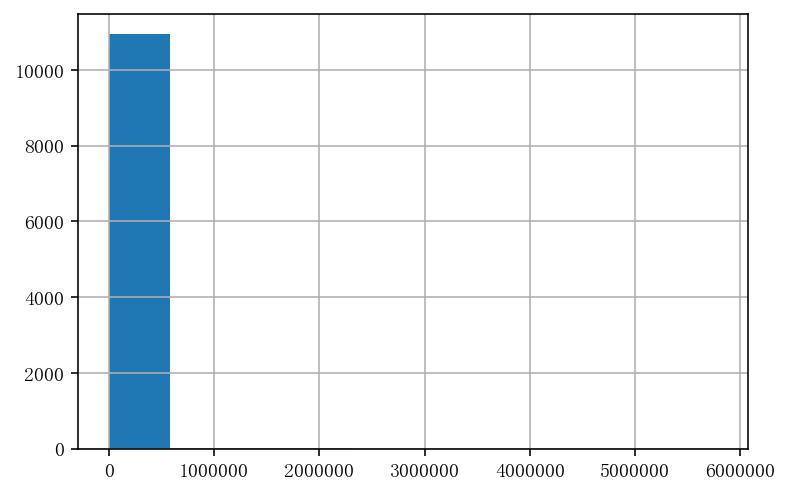

In [35]:
pht.平均人气.hist()   # 查看直方图

因为数据记录异常（爬不到人气值），人气值会被误记为0，且大主播的背后往往有财力的支持，人气影响因素受到机器人粉丝等其他影响，无法反应真正的受欢迎程度。所以对过高(Q1-1.5IQR)或过低(Q2-1.5IQR)的数据做删除处理。

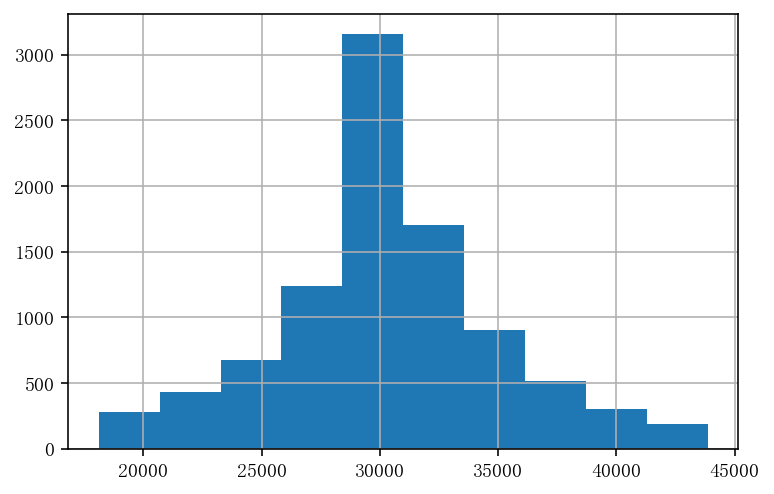

In [36]:
describe = pht.平均人气.describe(percentiles=[0.05, 0.25, 0.75, 0.95])
IQR = describe['75%'] - describe['25%']
下边缘 = describe['25%'] - 1.5 * IQR
上边缘 = describe['75%'] + 1.5 * IQR

pht[(pht.平均人气>下边缘)&(pht.平均人气<上边缘)].平均人气.hist()

In [37]:
pht = pht[(pht.平均人气>下边缘)&(pht.平均人气<上边缘)]   # 剔除异常值

去除了1758(15.7\%)条数据，还剩9387条数据。

##### 英雄数量
    1. 玩过几个英雄  
    2. 是否为热门英雄 + 英雄位置

In [38]:
# 当前玩的英雄
ht['attribute'].fillna('', inplace=True)                                                 # 填充缺失值
ht['英雄'] = ht['attribute'].apply(lambda x: re.findall("2': {'sContent': '(.*?)'", x))  # 提取ListPos2的sContent标签，即英雄
ht['英雄'] = ht['英雄'].apply(lambda x: x[0] if len(x)>0 else np.nan)

###### 1. 玩过几个英雄

In [39]:
LegCount_dict = ht.drop_duplicates(subset=['用户id', '英雄']).groupby('用户id').英雄.count().to_dict()
pht['英雄个数'] = pht.用户id.map(LegCount_dict)
pht.英雄个数.fillna(pht.英雄个数.mean(), inplace=True)           # 用均值填充缺失值，均值 = 1

###### 2.  英雄概况 = 是否为热门英雄 + 英雄位置

In [40]:
# 当前玩的英雄位置--'上单', '打野', '辅助', '下路', '中单'
with open('data\英雄位置字典.txt', 'r', encoding='utf-8') as f:
    position = eval(f.read())

ht['英雄位置'] = ht.英雄.map(position)
ht['英雄位置'] = ht['英雄位置'].fillna('未知')

In [41]:
ht['当前标签'] = ht['attribute'].apply(lambda x: re.findall("1': {'sContent': '(.*?)'", x)) # [上电视]、[大神推荐]等
ht['当前标签'] = ht['当前标签'].apply(lambda x: str(x)[1:-1])    # 去掉符号[]

热门英雄的定义：ht表中出现频次最高的前十个英雄

In [42]:
hot_leg = ht.英雄.value_counts().sort_values(ascending=False).iloc[:10].index 

ht.loc[ht.英雄.isin(hot_leg), '热门英雄'] = '热门'
ht.loc[(~ht.英雄.isna())&(~ht.英雄.isin(hot_leg)), '热门英雄'] = '非热门'
ht['热门英雄'] = ht['热门英雄'].fillna('未知')     # 用字符串填充，后续需要以字符串类型和字段`英雄位置`相加

对于ht表中没有检测出过英雄的主播（22\%）的数据，不做去除处理。  
考虑到未知英雄在`热门英雄`和`英雄位置`字段会出现共线性，所以将两个字段做<u>交互处理</u>。

先得到 热门+位置的字段，再对该字段`group by`，查看每个字段的人气值是否有显著不同。

In [43]:
dic = {'未知未知': '未知'}
ht['热门+位置'] = ht[['热门英雄','英雄位置']].sum(axis=1).apply(lambda x: dic.get(x, x))

> 缺点：
1. 英雄位置只能进行传统的匹配（查字典匹配），一个英雄只对应一个位置，和事实有出入。    
> 除此之外，还可以考虑版本强势英雄等。

对于pht表中的一个主播，显示人气最高的时候的热门+位置，如果人气最高时的英雄是未知，那么找下一个人气最高时的热门+位置。

In [44]:
# 数据提取思路：先将人气降序排序，然后去重用户id，保留第一个。提取{用户id: 热门+位置}的字典备用
IDHot_dict = ht[~ht.英雄.isna()].sort_values('totalCount', ascending=False).drop_duplicates(['用户id']).set_index('用户id')['热门+位置'].to_dict()
pht['英雄概况'] = pht.用户id.map(IDHot_dict)
pht.英雄概况.fillna('未知', inplace=True)         # 填充缺失值为未知

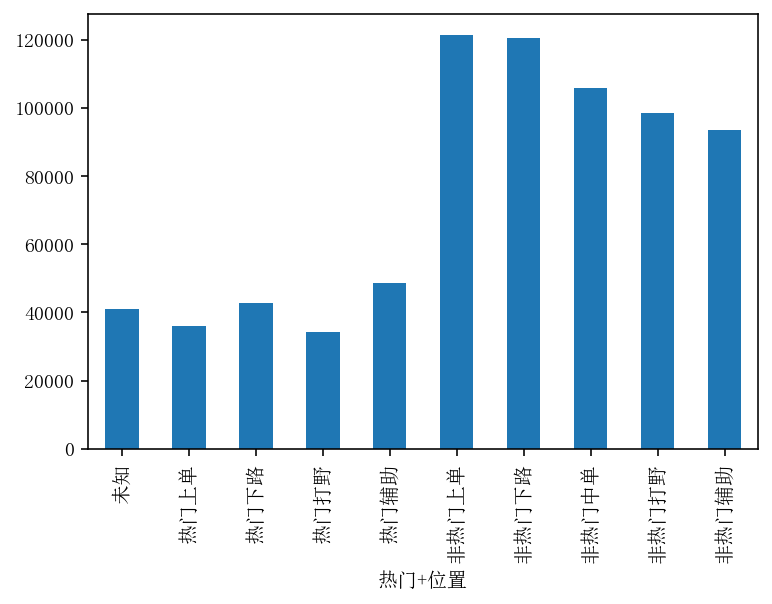

In [45]:
ht.groupby('热门+位置').totalCount.mean().plot(kind='bar')

可以明显看出，非热门英雄的人气值比热门英雄的人气值高，这可能是因为热门英雄供过于求，人数过多导致的拉低了人气平均水平。

##### 直播推荐标签  
[虎牙直播主机游戏品类推荐与标签申请规则总览](http://blog.huya.com/policy/537)

In [46]:
ht['标签'] = ht['attribute'].apply(lambda x: re.findall("1': {'sContent': '(.*?)'", x))  # 提取ListPos1的sContent标签，即标签，格式['上电视']
ht['标签'] = ht.标签.apply(lambda x: x[0] if len(x)==1 else np.nan)     # 去掉列表的括号[]

In [47]:
# 用出现最多次的标签作为当次主播开播的标签
# 提取{用户id：标签}思路：分别对每个用户id进行标签的value_counts，并且按降序排序，然后把作为index的用户id转为columns，方便对用户id去重，保留第一列，即保留了出现次数最大的标签。最后变为dict
tag_dict = ht.groupby('用户id').标签.value_counts(sort=True).rename('出现次数').reset_index().drop_duplicates('用户id').set_index('用户id').标签.to_dict()
pht['标签'] = pht.用户id.map(tag_dict)
pht.标签.fillna('无', inplace=True)

In [48]:
pht.标签.value_counts()

上电视     5677
大神推荐    2794
魅力新星     327
超粉之星     309
无        280
Name: 标签, dtype: int64

##### 直播标题的LDA主题提取

In [49]:
with open('data\用户id_直播标题字典.txt', 'r') as f:
    title_id_dict = eval(f.read())
# 段位较低（白银），以娱乐为主（快乐，克隆模式），新人直播标题（欢迎来到××的直播间，我是一颗小虎牙）—— 低段娱乐
# 段位较高（王者、艾欧尼亚、教学、），一起玩（黑色玫瑰、上车、车位、大乱斗）—— 高段开黑

In [50]:
pht['直播标题主题'] = pht.用户id.map(title_id_dict).map({'1':'低段娱乐', '2':'高段开黑'})

In [51]:
pht['直播标题主题'].value_counts()

低段娱乐    4722
高段开黑    4665
Name: 直播标题主题, dtype: int64

##### 公告LDA主题提取

In [52]:
with open('data\用户id_公告字典.txt', 'r') as f:
    ann_id_dict = eval(f.read())
# 主题1：大神直播
# 主题2：欢迎来到××的直播间，没有什么信息含量
# 主题3：新人求订阅
# 主题4：直播时段、打赏机制

In [53]:
公告_主题号_主题名_字典 = {'1':'能力描述', '2':'缺少信息', '3':'新人求订阅','4':'时段&粉丝机制'}
pht['公告主题'] = pht.用户id.map(ann_id_dict).map(公告_主题号_主题名_字典)

In [54]:
pht.公告主题.value_counts()

缺少信息       4704
时段&粉丝机制    2079
新人求订阅      1396
能力描述       1208
Name: 公告主题, dtype: int64

##### 直播时长

上半天直播时长

In [55]:
# 上半天天直播开始时间
a = ht[ht.get_time<'2021-04-04 12:40:00'].groupby('用户id').get_time.min().rename('上半天直播开始时间')
pht = pd.merge(pht, a, on='用户id', how='left')

# 上半天天直播结束时间
a = ht[ht.get_time<'2021-04-04 12:40:00'].groupby('用户id').get_time.max().rename('上半天直播结束时间')
pht = pd.merge(pht, a, on='用户id', how='left')

# 上半天直播时长
pht['上半天直播时长'] = (pht['上半天直播结束时间'] - pht['上半天直播开始时间']).fillna(0)
pht['上半天直播时长'] = pht.上半天直播时长.apply(lambda x: x.total_seconds()/(60*60))  # 转为小时

D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  # Remove the CWD from sys.path while we load stuff.


下半天直播时长

In [56]:
# 下半天天直播开始时间
a = ht[ht.get_time>='2021-04-04 12:40:00'].groupby('用户id').get_time.min().rename('下半天直播开始时间')
pht = pd.merge(pht, a, on='用户id', how='left')

# 下半天天直播结束时间
a = ht[ht.get_time>='2021-04-04 12:40:00'].groupby('用户id').get_time.max().rename('下半天直播结束时间')
pht = pd.merge(pht, a, on='用户id', how='left')

# 下半天直播时长
pht['下半天直播时长'] = (pht['下半天直播结束时间'] - pht['下半天直播开始时间']).fillna(0)
pht['下半天直播时长'] = pht.下半天直播时长.apply(lambda x: x.total_seconds()/(60*60))  # 转为小时

D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  # Remove the CWD from sys.path while we load stuff.


In [57]:
pht['直播时长'] = pht.上半天直播时长 + pht.下半天直播时长
pht.drop(columns=['上半天直播时长','下半天直播时长'], inplace=True)            # 删除掉计算的中间字段

因为数据爬取是间隔性的，无法准确测量直播时长，所以为了降低异常值的影响，增加模型的稳定性，对`直播时长`采用分箱处理。  
2小时以下（50%以下），2-6（50-75%），6小时以上（75%以上）

In [58]:
pht['直播时长'].describe()

count    9387.000000
mean        3.892445
std         4.778028
min         0.000000
25%         0.015556
50%         2.023333
75%         6.010278
max        23.295556
Name: 直播时长, dtype: float64

In [59]:
pht['直播时长_分箱'] = pd.cut(pht.直播时长, bins=[-1,2,6,25]) # , labels=['<2','2-6','6-10','>10']

##### 在播时段：  
  
    14:00 - 01:00 黄金时段  大于均值  
    01:00 - 14:00 非黄金时段  小于均值  

In [60]:
def get_hour(t):
    return t.hour if t else np.nan
pht['上半天直播开始时间点'] = pht.上半天直播开始时间.map(get_hour).fillna(-1)  # -1填充，方便下一步的运算
pht['下半天直播开始时间点'] = pht.下半天直播开始时间.map(get_hour).fillna(-1)

pht['开始直播时间点'] = pht[['上半天直播开始时间点','下半天直播开始时间点']].apply(lambda x: x[0] if x[0]>x[1] else x[1], axis=1)

In [61]:
pht['活跃时间'] = pd.cut(pht.开始直播时间点, bins=[0, 1, 14, 25], labels=['黄金时段_2', '非黄金时段',  '黄金时段'], right=False).apply(lambda x: x[:4])

##### 蓝光  
    是否有蓝光
    蓝光清晰度

###### 是否有蓝光

In [62]:
a = ht.drop_duplicates('用户id')[['用户id','isBluRay']].rename(columns={'isBluRay':'是否蓝光'})
pht = pd.merge(pht, a, on='用户id', how='left')

###### 蓝光清晰度
    4M以下：中清晰度  80%
    4M以上：高清晰度  20%

In [63]:
blueRay_dict = ht.groupby('用户id')['用户id','bluRayMBitRate'].head(1).set_index('用户id').bluRayMBitRate.apply(lambda x: x[:-1]).to_dict()
pht['蓝光清晰度'] = pht.用户id.map(blueRay_dict).astype('float')

In [64]:
pht['蓝光清晰度'] = pd.cut(pht.蓝光清晰度, bins=[0,4,100], labels=['4M以下', '4M以上'])

#### 个人信息表

In [65]:
pi = pd.read_csv('data\个人信息.csv')   # personal_infomation 个人信息表

D:\software\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


个人信息表pi:
- 用户id
- 标签
- 上次开播时间
- 省份
- 城市
- sex: 性别
- fans: 订阅量
- 个人等级——观看直播获得的等级
- 主播等级——开播获得的等级

##### 地区

省份所在区域

In [66]:
province_dict = pi.set_index('用户id').省份.to_dict()
pht['省份'] = pht.用户id.map(province_dict)

In [67]:
# 省份映射到区域   
with open('data\省份所在区域字典.txt', 'r', encoding='utf-8') as f:
    proDic = eval(f.read())

pht['区域'] = pht.省份.map(proDic)  # '华东', '未知', '华北', '西南', '华中', '华南', '东北', '西北', '海外'

城市：前线城市、非前线城市

In [68]:
province_dict = pi.set_index('用户id').城市.to_dict()
pht['城市'] = pht.用户id.map(province_dict)

In [69]:
qxCity = ['北京','上海','广州','深圳','成都','重庆','杭州','武汉','西安','郑州','青岛','长沙','天津','苏州','南京','东莞','沈阳','合肥','佛山','昆明','福州','无锡','厦门','哈尔滨','长春','南昌','济南','宁波','大连','贵阳','温州','石家庄','泉州','南宁','金华','常州','珠海','惠州','嘉兴','南通','中山','保定','兰州','台州','徐州','太原','绍兴','烟台','廊坊']
pht.loc[pht.城市.isin(qxCity), '是否为前线城市'] = 1
pht.loc[~pht.城市.isin(qxCity), '是否为前线城市'] = 0

##### 性别、订阅量、个人等级、主播等级

In [70]:
# 性别有6000+条缺失值，用朴素贝叶斯进行填充。
with open('data\用户id_性别字典.txt', 'r') as f:
    sex_dict = eval(f.read())
    
pht['性别'] = pht.用户id.map(sex_dict)

In [71]:
personal_data_dict = pi.set_index('用户id')[['fans','个人等级','主播等级']].rename(columns={'fans':'订阅量'}).to_dict()
for key, values in personal_data_dict.items():
    pht[key] = pht.用户id.map(values)

考虑到字段`订阅量`缺失值过多，且订阅量分布右偏严重，故对`订阅量`字段做分箱处理（按百分比分箱）。

In [72]:
pht.订阅量.describe()

count      3195.000000
mean       3384.297966
std       19646.072402
min           0.000000
25%          13.000000
50%          63.000000
75%         734.000000
max      627714.000000
Name: 订阅量, dtype: float64

15、60、700、缺失

In [73]:
pht['订阅量'] = pd.qcut(pht.订阅量, q=[0,0.25,0.5,0.75,1], labels=['15以下','15-60', '60-700','700以上']).astype(str)

#### 保存数据

In [74]:
# 删除掉不需要的字段 
pht.drop(columns=['上半天直播开始时间', '上半天直播结束时间', '下半天直播开始时间', '下半天直播结束时间', '直播时长','上半天直播开始时间点', '下半天直播开始时间点', '开始直播时间点',
                  '是否为钻石公会','公会规模','省份','城市'], inplace=True)

In [75]:
pht.head()

用户id     平均人气  贡献榜总人数  贡献榜总金额  是否有收入  贡献榜平均用户等级  高等级用户数  高等级用户数占比  \
0     2456843900  18115.0     0.0     0.0      0       -1.0     0.0       0.0   
1  1279528989523  18132.0     0.0     0.0      0       -1.0     0.0       0.0   
2     1579765664  18156.0     0.0     0.0      0       -1.0     0.0       0.0   
3  1199549875013  18166.0     0.0     0.0      0       -1.0     0.0       0.0   
4  1199536558238  18196.0     0.0     0.0      0       -1.0     0.0       0.0   

   贵族数  金主数量  贡献榜人均金额  广泛贡献用户数  守护者个数  视频平均时长  视频平均每周更新频率  视频平均点赞数  视频平均评论数  \
0  0.0   0.0      0.0      0.0    0.0    30.8    0.416667      0.0      0.0   
1  0.0   0.0      0.0      0.0    0.0     0.0    0.000000      0.0      0.0   
2  0.0   0.0      0.0      0.0    0.0     0.0    0.000000      0.0      0.0   
3  0.0   0.0      0.0      0.0    0.0     0.0    0.000000      0.0      0.0   
4  0.0   0.0      0.0      0.0    0.0     0.0    0.000000      0.0      0.0   

   视频平均分享数  视频平均观看次数     公会概况  英雄个数  英雄概况    标签 直播标题主题   公告主题  直播时长_分箱  活跃时间  \
0      0.2     560.2      无公会     1  热门上单   上电视   高段开黑   缺少信息  (-1, 2]  非黄金时   
1      0.0       0.0      无公会     0    未知   上电视   低段娱乐   缺少信息  (-1, 2]  黄金时段   
2      0.0       0.0  白金小规模公会     1  热门上单  超粉之星   高段开黑   缺少信息  (-1, 2]  黄金时段   
3      0.0       0.0      无公会     0    未知  大神推荐   高段开黑  新人求订阅  (-1, 2]  黄金时段   
4      0.0       0.0      无公会     1  热门上单   上电视   低段娱乐   缺少信息  (-1, 2]  黄金时段   

   是否蓝光 蓝光清晰度  区域  是否为前线城市   性别     订阅量  个人等级  主播等级  
0     1  4M以下  西北      1.0  1.0     nan   1.0  17.0  
1     1  4M以下  华南      0.0  1.0     nan  11.0   4.0  
2     1  4M以下  华东      1.0  1.0  60-700   2.0  12.0  
3     1  4M以下  华中      1.0  1.0  60-700   3.0  13.0  
4     0  4M以下  华东      0.0  2.0     nan   2.0   6.0

In [92]:
pht.to_csv('data\主播数据(处理后).csv', index=False)